In [22]:
import torch as th
import torch
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr
import torch.nn.functional as F
import networkx as nx
from math import sin, pi, cos
from matplotlib.path import Path
import matplotlib.pyplot as plt
import math
from functools import reduce

In [23]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, dim):
        # In the new version grad will be separate, so image gradients will not be here
        # Normal initialization of Snake super class
        super().__init__(graph, crop, stepsz, alpha, beta, dim)
        # Additionally we sample from a normal distrubution for widths of nodes
        #self.w = torch.randn(self.s.shape[0]).abs()
        self.w = torch.randint(low=2, high=9, size=(self.s.shape[0],), dtype=torch.float32)

    def cuda(self):
        super().cuda()
        # move the widths to gpu
        self.w = self.w.cuda()

    def set_w(self, widths):
        self.w = widths

    def get_w(self):
        return self.w

    def _compute_normals(self, pos):
        """
        Compute normals (and tangents for 3D) for each center point.
        Returns:
         - 2D: (normals,) where normals is (N,2)
         - 3D: (n1, n2, tangents) each (N,3)
        """
        N, d = pos.shape
        eps = 1e-8
        t = torch.zeros_like(pos)
        if N > 1:
            t[1:-1] = (pos[2:] - pos[:-2]) * 0.5
            t[0] = pos[1] - pos[0]
            t[-1] = pos[-1] - pos[-2]
        t = t / (t.norm(dim=1, keepdim=True) + eps)

        if self.ndims == 2:
            normals = torch.stack([-t[:,1], t[:,0]], dim=1)
            normals = normals / (normals.norm(dim=1, keepdim=True) + eps)
            return (normals,)
        else:
            a = torch.zeros_like(pos)
            a[:] = torch.tensor([1.0, 0.0, 0.0], device=pos.device)
            mask = (t * a).abs().sum(dim=1) > 0.9
            a[mask] = torch.tensor([0.0, 1.0, 0.0], device=pos.device)
            n1 = torch.cross(t, a, dim=1)
            n1 = n1 / (n1.norm(dim=1, keepdim=True) + eps)
            n2 = torch.cross(t, n1, dim=1)
            n2 = n2 / (n2.norm(dim=1, keepdim=True) + eps)
            return (n1, n2, t)
        
    def comp_second_deriv(self):
        """
        Computes an internal smoothness term for widths, related to the second derivative,
        using 1D convolution. Handles boundaries using padding.
        A positive value indicates the width should shrink to increase smoothness,
        a negative value indicates it should grow.
        Returns:
            torch.Tensor: Smoothness term for each node, shape (K, 1).
        """
        K = self.w.numel()
        if K < 3:
             return torch.zeros(K, 1, device=self.w.device, dtype=self.w.dtype)

        w = self.w.view(1, 1, -1)

        kernel = torch.tensor([[[1.0, -2.0, 1.0]]], device=w.device, dtype=w.dtype) # Shape (1, 1, 3)
        padding_size = (kernel.shape[-1] - 1) // 2
        w_padded = F.pad(w, (padding_size, padding_size), mode='replicate')
        smoothness_term = F.conv1d(w_padded, kernel, padding=0)
        return -smoothness_term.view(-1, 1) # Shape (K, 1)

    def step_widths(self, gimgW):
        """
        Update widths by sampling gradient of image W at ribbon edges and
        adding internal smoothness via second derivative.
        Handles leaf nodes using padded convolution for smoothness.
        """
        if self.s.numel() == 0:
            return self.w

        pos = self.s
        K, d = pos.shape
        device = pos.device
        w_vec = self.w.view(-1)
        half_r = (w_vec / 2.0).view(K, 1)

        if d == 2:
            (normals,) = self._compute_normals(pos)
            left_pts  = pos - normals * half_r    
            right_pts = pos + normals * half_r    
            grad_L = cmptExtGrad(left_pts,  gimgW)
            grad_R = cmptExtGrad(right_pts, gimgW)
            grad_w = ((grad_R - grad_L) * normals).sum(dim=1, keepdim=True)

        elif d == 3:
            n1, n2, _ = self._compute_normals(pos)
            N_samples = 8
            theta = torch.linspace(0, 2*math.pi, N_samples + 1, device=device, dtype=pos.dtype)[:-1]
            theta_exp = theta.view(N_samples, 1, 1)
            n1_exp = n1.unsqueeze(0)                
            n2_exp = n2.unsqueeze(0)                
            half_r_exp = half_r.view(1, K, 1)       
            pos_exp = pos.unsqueeze(0)              
            dirs = theta_exp.cos() * n1_exp + theta_exp.sin() * n2_exp
            epsilon_offset = 1e-4
            pts_out = pos_exp + (half_r_exp + epsilon_offset) * dirs  
            pts_in  = pos_exp - (half_r_exp + epsilon_offset) * dirs  
            all_pts = torch.cat([pts_out, pts_in], dim=0) 
            all_pts_flat = all_pts.view(-1, 3)           
            grads_flat = cmptExtGrad(all_pts_flat, gimgW)
            grads = grads_flat.view(2*N_samples, K, 3)   
            grads_out = grads[:N_samples]
            grads_in  = grads[N_samples:]
            grad_diff = grads_out - grads_in
            radial_component = (grad_diff * dirs).sum(dim=2)
            grad_w = radial_component.mean(dim=0, keepdim=True).t()

        else:
            raise ValueError(f"Unsupported dimension: {d}")

        internal = self.comp_second_deriv()
        alpha = grad_w.abs() / (internal.abs().max(torch.tensor(1e-8, device=device)))
        alpha = torch.clamp(alpha, max=10.0)
        total_gradient = -grad_w - alpha * internal

        # gradient descent step: w_new = w_old - stepsz * total_gradient
        self.w = w_vec + self.stepsz * total_gradient.squeeze(-1)
        self.w = torch.clamp(self.w, min=1e-4)
        return self.w
    
    def render_distance_map_with_widths(self, size, max_dist=16.0):
        """
        Unified 2D/3D signed distance map for the ribbon snake using graph structure.

        Args:
            size (tuple): (W, H) for 2D or (X, Y, Z) for 3D grid dimensions.
            max_dist (float): Maximum distance value to clamp to.

        Returns:
            torch.Tensor: Signed distance map of shape `size`. Negative inside,
                          zero on surface, positive outside up to max_dist.
        """
        device = self.s.device
        centers = self.s
        radii = (self.w.flatten() / 2.0)
        eps = 1e-8

        if centers.numel() == 0 or radii.numel() == 0 or len(self.h.nodes) == 0:
            print("Warning: Rendering distance map for empty snake.")
            return torch.full(size, max_dist, device=device, dtype=centers.dtype)

        if centers.shape[0] != radii.shape[0]:
             raise ValueError(f"Mismatch between center points ({centers.shape[0]}) and radii ({radii.shape[0]})")

        axes = [torch.arange(sz, device=device, dtype=torch.float32) for sz in size]
        mesh = torch.meshgrid(*axes, indexing='ij')
        points = torch.stack([m.flatten() for m in mesh], dim=1)
        num_points = points.shape[0]
        min_dist = torch.full((num_points,), float('inf'), device=device, dtype=centers.dtype)

        if len(self.h.edges) > 0:
            try:
                if hasattr(self, 'n2i') and self.n2i:
                     edge_indices_list = [(self.n2i[u], self.n2i[v]) for u, v in self.h.edges]
                else:
                     edge_indices_list = list(self.h.edges)

                edge_indices = torch.tensor(edge_indices_list, device=device, dtype=torch.long) # (E, 2)
                del edge_indices_list
            except KeyError as e:
                 raise RuntimeError(f"Node ID {e} from graph edges not found in n2i mapping. Ensure Snake init populated n2i correctly.") from e
            except Exception as e:
                 raise RuntimeError(f"Error processing graph edges. Ensure self.h and self.n2i are correct. Original error: {e}")


            starts = centers[edge_indices[:, 0]]
            ends   = centers[edge_indices[:, 1]]
            r0     = radii[edge_indices[:, 0]]
            r1     = radii[edge_indices[:, 1]]

            vec = ends - starts
            L_sq = (vec**2).sum(dim=1)
            valid_edge = L_sq > eps**2
            if torch.any(valid_edge):
                 starts_v, ends_v = starts[valid_edge], ends[valid_edge]
                 r0_v, r1_v = r0[valid_edge], r1[valid_edge]
                 vec_v = vec[valid_edge]
                 L_sq_v = L_sq[valid_edge]
                 L_v = torch.sqrt(L_sq_v)
                 D_v = vec_v / (L_v.unsqueeze(1) + eps)

                 P_exp = points.unsqueeze(1)
                 S_exp = starts_v.unsqueeze(0)
                 D_exp = D_v.unsqueeze(0)
                 L_exp = L_v.unsqueeze(0)

                 v_point_start = P_exp - S_exp
                 proj = (v_point_start * D_exp).sum(dim=2)
                 t = torch.clamp(proj, min=torch.tensor(0.0, device=device), max=L_exp)

                 closest_on_axis = S_exp + D_exp * t.unsqueeze(-1)
                 dist_axis_sq = ((P_exp - closest_on_axis)**2).sum(dim=2)
                 frac = t / torch.clamp(L_exp, min=eps)
                 r0_exp = r0_v.unsqueeze(0)
                 r1_exp = r1_v.unsqueeze(0)
                 interp_radius = r0_exp * (1.0 - frac) + r1_exp * frac
                 dist_sq_capsule = dist_axis_sq - interp_radius**2
                 dist_axis = torch.sqrt(torch.clamp(dist_axis_sq, min=0.0))
                 signed_dist_capsule = dist_axis - interp_radius
                 min_dist_capsule, _ = signed_dist_capsule.min(dim=1)

                 min_dist = torch.minimum(min_dist, min_dist_capsule)
                 # P_exp is still needed for sphere calculation

        if centers.shape[0] > 0:
            # Reuse P_exp if it exists from capsule calculation
            if 'P_exp' not in locals():
                P_exp = points.unsqueeze(1)
            C_exp = centers.unsqueeze(0)
            R_exp = radii.unsqueeze(0)
            dist_to_centers_sq = ((P_exp - C_exp)**2).sum(dim=2)
            dist_to_centers = torch.sqrt(torch.clamp(dist_to_centers_sq, min=0.0))

            signed_dist_sphere = dist_to_centers - R_exp
            min_dist_sphere, _ = signed_dist_sphere.min(dim=1)
            min_dist = torch.minimum(min_dist, min_dist_sphere)

        dist_clamped = torch.clamp(min_dist, max=max_dist)
        return dist_clamped.reshape(*size)

In [24]:
def makeGaussEdgeFltr(stdev,d):
    # make a Gaussian-derivative-based edge filter
    # filter size is determined automatically based on stdev
    # the filter is ready to be used with pytorch conv 
    # input params:
    #   stdev - the standard deviation of the Gaussian
    #   d - number of dimensions
    # output:
    #   fltr, a np.array of size d X 1 X k X k,
    #         where k is an odd number close to 4*stdev
    #         fltr[i] contains a filter sensitive to gradients
    #         along the i-th dimension

    fsz=round(2*stdev)*2+1 # filter size - make the it odd

    n=np.arange(0,fsz).astype(float)-(fsz-1)/2.0
    s2=stdev*stdev
    v=np.exp(-n**2/(2*s2)) # a Gaussian
    g=n/s2*v # negative Gaussian derivative

    # create filter sensitive to edges along dim0
    # by outer product of vectors
    shps = np.eye(d,dtype=int)*(fsz-1)+1
    reshaped = [x.reshape(y) for x,y in zip([g]+[v]*(d-1), shps)]
    fltr=reduce(np.multiply,reshaped)
    fltr=fltr/np.sum(np.abs(fltr))
    
    # add the out_channel, in_channel initial dimensions
    fltr_=fltr[np.newaxis,np.newaxis]
    # transpose the filter to be sensitive to edges in all directions 
    fltr_multidir=np.concatenate([np.moveaxis(fltr_,2,k) for k in range(2,2+d)],axis=0)
    
    return fltr_multidir

def cmptGradIm(img,fltr):
    # convolves img with fltr, with replication padding
    # fltr is assumed to be of odd size
    # img  is either 2D: batch X channel X height X width
    #             or 3D: batch X channel X height X width X depth
    #      it is a torch tensor
    # fltr is either 2D: 2 X 1 X k X k
    #             or 3D: 3 X 1 X k X k X k
    #      it is a torch tensor
    
    if img.dim()==4:
        img_p=torch.nn.ReplicationPad2d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv2d(img_p,fltr)
    if img.dim()==5:
        img_p=torch.nn.ReplicationPad3d(fltr.shape[2]//2).forward(img)
        return torch.nn.functional.conv3d(img_p,fltr)
    else:
        raise ValueError("img should have 4 or 5 dimensions")

def cmptExtGrad(snakepos,eGradIm):
    # returns the values of eGradIm at positions snakepos
    # snakepos  is a k X d matrix, where snakepos[j,:] represents a d-dimensional position of the j-th node of the snake
    # eGradIm   is a tensor containing the energy gradient image, either of size
    #           3 X d X h X w, for 3D, or of size
    #           2     X h X w, for 2D snakes
    # returns a tensor of the same size as snakepos,
    # containing the values of eGradIm at coordinates specified by snakepos
    
    # scale snake coordinates to match the hilarious requirements of grid_sample
    # we use the obsolote convention, where align_corners=True
    scale=torch.tensor(eGradIm.shape[1:]).reshape((1,-1)).type_as(snakepos)-1.0
    sp=2*snakepos/scale-1.0
    
    if eGradIm.shape[0]==3:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('km,md->kd',[sp,torch.tensor([[0,0,1],[0,1,0],[1,0,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,4,1)
    if eGradIm.shape[0]==2:
        # invert the coordinate order to match other hilarious specs of grid_sample
        spi=torch.einsum('kl,ld->kd',[sp,torch.tensor([[0,1],[1,0]]).type_as(sp).to(sp.device)])
        egrad=torch.nn.functional.grid_sample(eGradIm[None],spi[None,None],
                                           align_corners=True)
        egrad=egrad.permute(0,2,3,1)
        
    return egrad.reshape_as(snakepos)

class GradImRib(RibbonSnake):
    def __init__(self, graph, crop,stepsz, alpha, beta, dim, gimgV, gimgW):
        super().__init__(graph, crop,stepsz, alpha, beta, dim)

        self.gimgV = gimgV.clone()
        self.gimgW = gimgW.clone()
    
    def cuda(self):
        super().cuda()
        if self.gimgV is not None:
            self.gimgV = self.gimgV.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()

    def step(self):
        return super().step(cmptExtGrad(self.s, self.gimgV))
    
    def step_widths(self):
        return super().step_widths(self.gimgW)
    
    def optim(self, niter):
        if len(self.s) > 0:
            for i in range(niter):
                if i < niter / 2:
                    self.step() # problem var gradient bozuyor
                else:
                    self.step_widths()
        return self.s

In [25]:
def show_slices(distance_map, graph):
    """Show orthogonal slices through the distance map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    xx = np.min(distance_map, axis=0)
    yy = np.min(distance_map, axis=1)
    zz = np.min(distance_map, axis=2)
    
    im0 = axes[0].imshow(xx.T, cmap='coolwarm')
    axes[0].set_title('Slice (X)')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(yy.T, cmap='coolwarm')
    axes[1].set_title('Slice (Y)')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(zz.T, cmap='coolwarm')
    axes[2].set_title('Slice (Z)')
    fig.colorbar(im2, ax=axes[2])

    for edge in graph.edges:
        node1, node2 = edge
        x1, y1, z1 = graph.nodes[node1]['pos']
        x2, y2, z2 = graph.nodes[node2]['pos']
        
        axes[0].plot([y1, y2], [z1, z2], 'r-')
        axes[1].plot([x1, x2], [z1, z2], 'r-')
        axes[2].plot([x1, x2], [y1, y2], 'r-')
    
    plt.show()

In [26]:
def show(img,title,graph=None):
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.show()

# With Loss

In [27]:
import torch.nn as nn
import torch.optim as optim

In [37]:
class SnakeFastLoss(nn.Module):
    def __init__(self, stepsz, alpha, beta, fltrstdev, ndims, nsteps,
                 cropsz, dmax, maxedgelen, extgradfac):
        super(SnakeFastLoss, self).__init__()
        self.stepsz = stepsz
        self.alpha = alpha
        self.beta = beta
        self.fltrstdev = fltrstdev
        self.ndims = ndims
        self.cropsz = cropsz
        self.dmax = dmax
        self.maxedgelen = maxedgelen
        self.extgradfac = extgradfac
        self.nsteps = nsteps

        self.fltr = makeGaussEdgeFltr(self.fltrstdev, self.ndims)
        self.fltrt = torch.from_numpy(self.fltr).type(torch.float32)

        self.iscuda = False

    def cuda(self):
        super(SnakeFastLoss, self).cuda()
        self.fltrt = self.fltrt.cuda()
        self.iscuda = True
        return self

    def forward(self, pred_dmap, lbl_graphs, crops=None, mask= None):
        # pred_dmap is the predicted distance map from the UNet
        # lbl_graphs contains graphs each represent a label as a snake
        # crops is a list of slices, each represents the crop area of the corresponding snake

        pred_ = pred_dmap
        dmapW = torch.abs(pred_).clone()
        gimgW = cmptGradIm(dmapW, self.fltrt)
        gimg = cmptGradIm(pred_, self.fltrt)
        gimg *= self.extgradfac
        gimgW *= self.extgradfac
        snake_dmap = []

        for i, lg in enumerate(zip(lbl_graphs, gimg, gimgW)):
            # i is index num
            # lg is a tuple of a graph and a gradient image
            l = lg[0]  # graph
            g = lg[1]  # gradient image
            gw = lg[2]

            s = GradImRib(graph=l, crop=None, stepsz=self.stepsz, alpha=self.alpha,
                        beta=self.beta,dim=self.ndims, gimgV=g, gimgW=gw)
                    
            if self.iscuda: 
                s.cuda()

            s.optim(self.nsteps)
            dmap = s.render_distance_map_with_widths(g[0].shape)
            #show_slices(dmap.numpy(), l)
            if mask is not None:
                dmap = dmap * (mask==0)
            snake_dmap.append(dmap)

        snake_dm = torch.stack(snake_dmap, 0).unsqueeze(1)   
        loss = ((pred_dmap - snake_dm)**2).mean()
        self.snake = s
        return loss

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_25973/3712843903.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


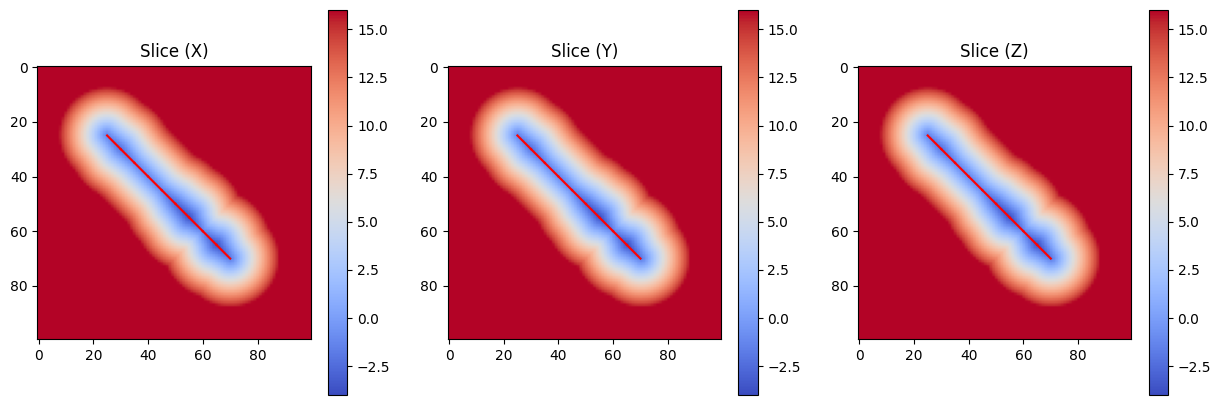

In [38]:
g = nx.Graph()
#widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop,stepsz, alpha, beta, dim=ndims)
#s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect), g)


pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [39]:
s.get_w()

tensor([3., 5., 3., 3., 3., 6., 8., 3., 8., 4.])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_25973/456995463.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.abs()), g)


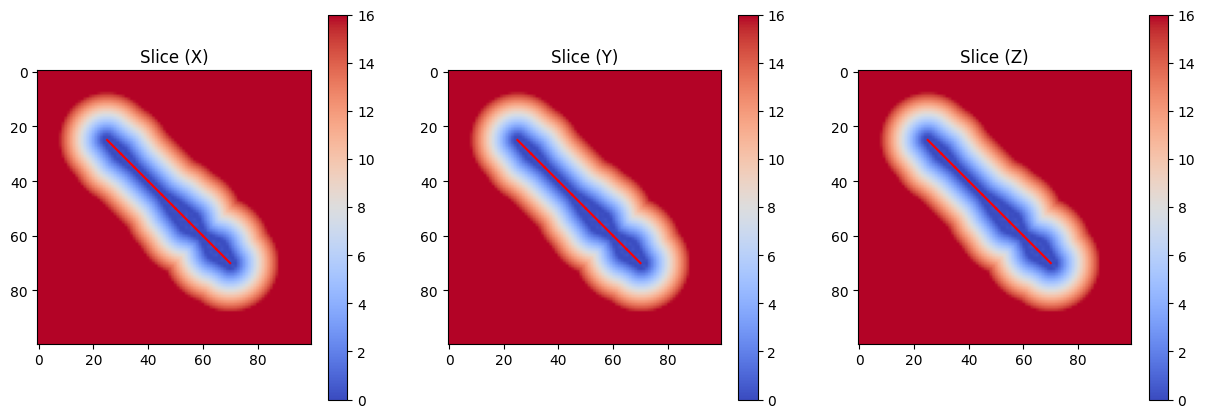

In [40]:
show_slices(np.array(pred_perfect.abs()), g)

In [41]:
pred_initial2[:,:,33:34,:,:] = 16.0
pss = pred_initial2[0][0]

In [42]:
pss.shape

torch.Size([100, 100, 100])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_25973/2399199909.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pss), g)


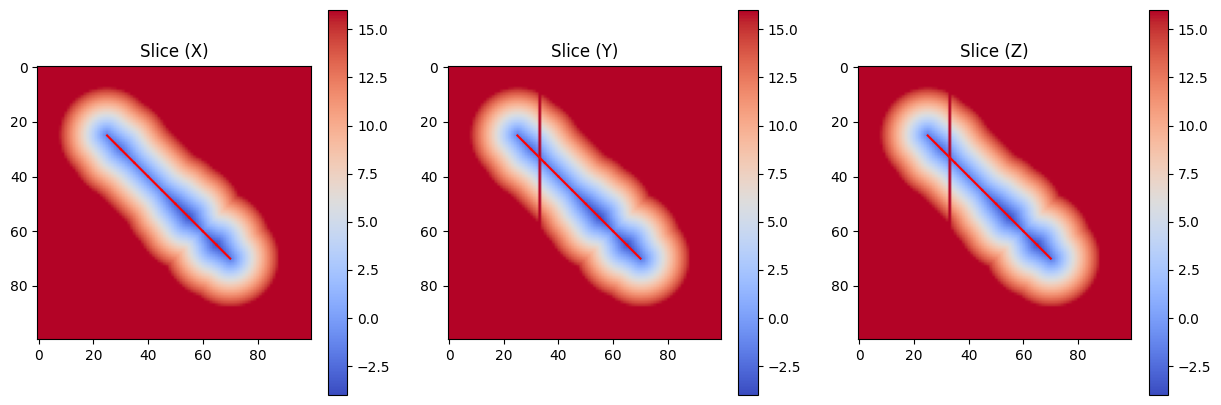

In [43]:
show_slices(np.array(pss), g)

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_25973/1146723498.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect.detach()), g)


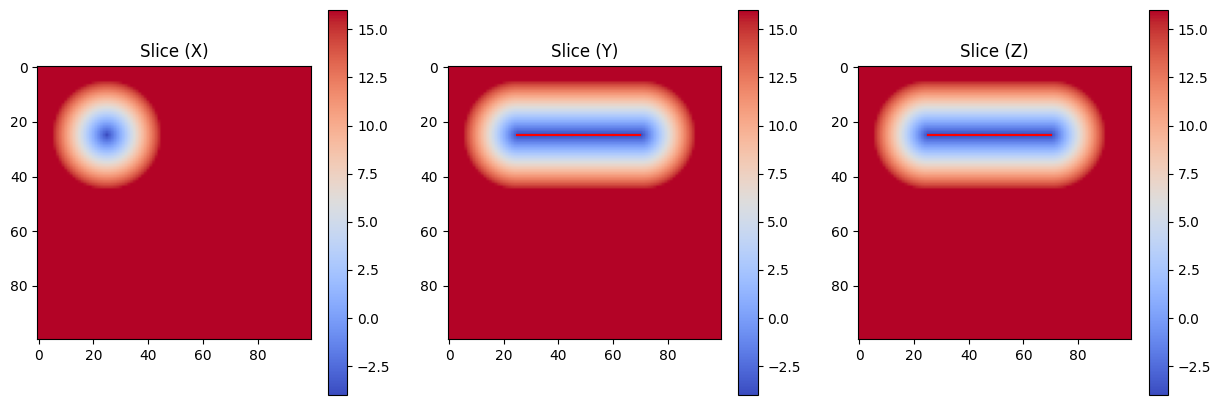

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_25973/1146723498.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_initial2[0][0].detach()), g)


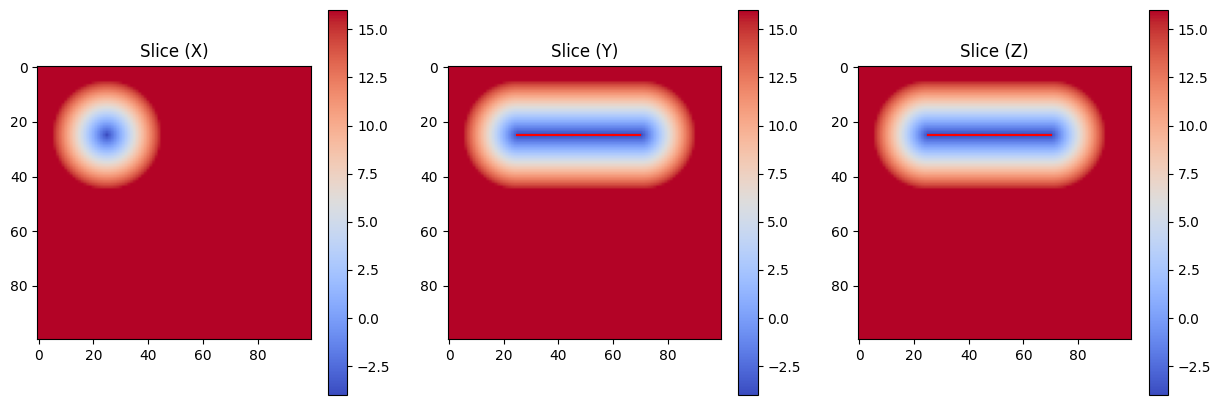

Iteration 0, Loss: 0.008457097224891186


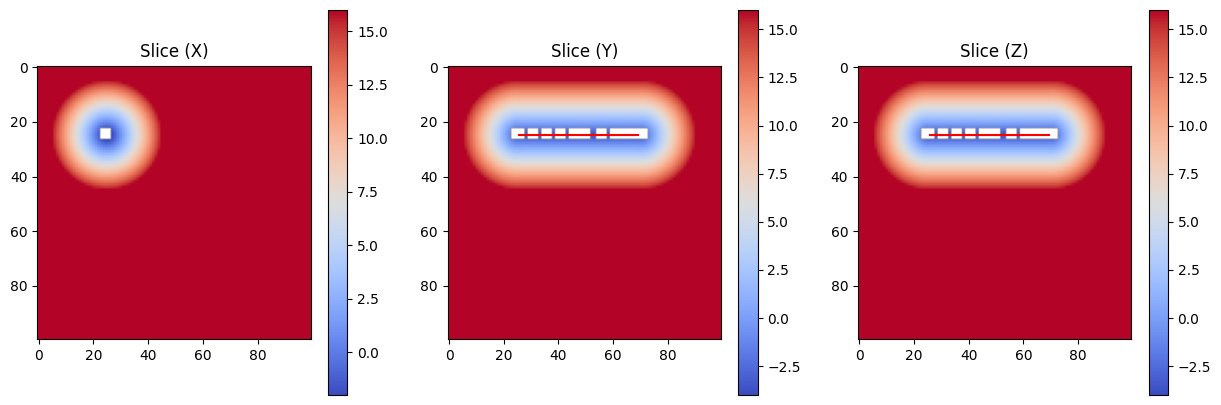

Iteration 10, Loss: nan


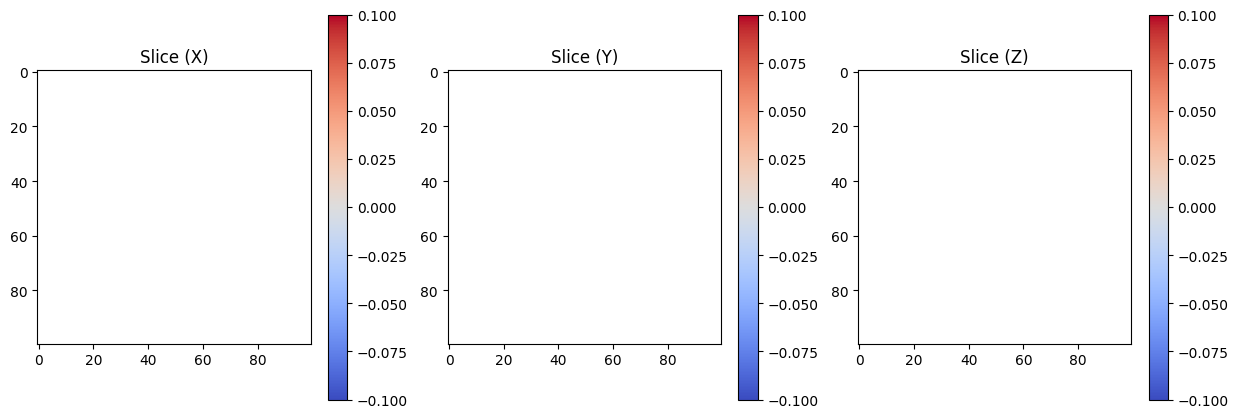

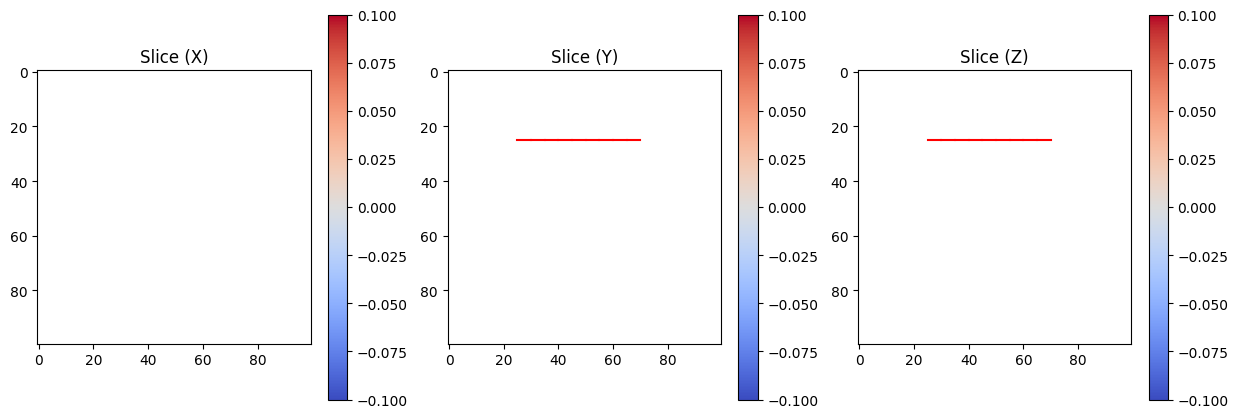

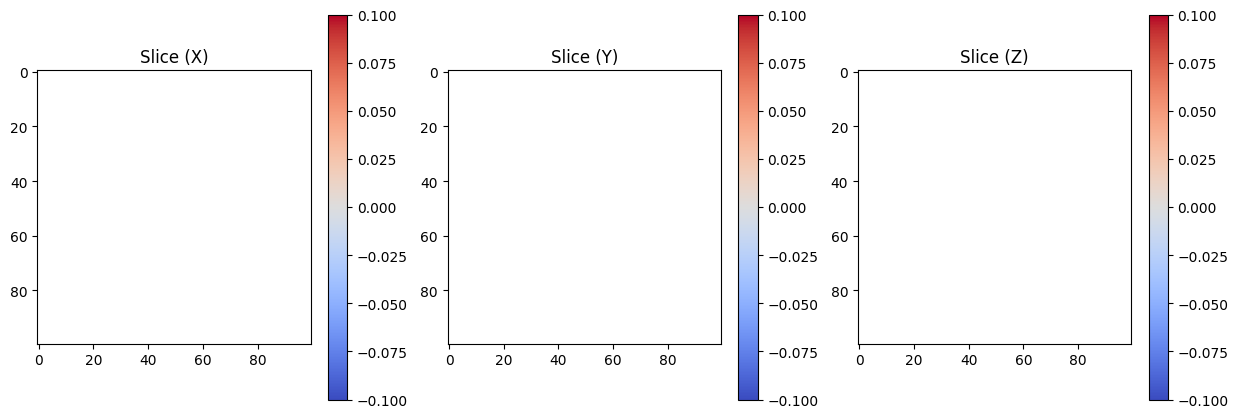

In [44]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)

""" g.add_node(16, pos=np.array([25,40,40]))
g.add_edge(16,5)
g.add_node(17, pos=np.array([50,40,30]))
g.add_edge(17,10) """
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0001
beta = 0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop,stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100,100))
 
show_slices(np.array(pred_perfect.detach()), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
#pred_initial2[:,:,:,33:34,:] = 10.0

""" pred=pred_initial.clone()
pred.requires_grad_(True) """
pred2=pred_initial2.clone().detach()
pred2.requires_grad_(True)

""" for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10,0])  """

show_slices(np.array(pred_initial2[0][0].detach()), g)

fltrstdev=0.5

opt = optim.SGD([pred2], lr=0.001, momentum=0.0)

extgradfac=1.0
nsteps=20
loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps
                        ,crop    ,16,4,extgradfac)

for i in range(20):
    opt.zero_grad()
    loss_val = loss.forward(pred2, [g])
    loss_val.backward()
    # optimization is done on pred2
    opt.step()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss_val.item()}")
    if i % 10 == 0:
        show_slices(pred2.clone().detach()[0][0].numpy(), loss.snake.getGraph())

show_slices(pred2.detach().cpu().numpy()[0, 0], g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show_slices(final_pred[0][0].numpy(), loss.snake.getGraph())

In [36]:
loss.snake.get_w()

tensor([7.8563, 7.8643, 7.8529, 7.8487, 7.8214, 7.8379, 7.8186, 7.8371, 7.8176,
        7.8293])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_23451/1058957804.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(loss.snake.render_distance_map_with_widths((100,100,100)).detach()), loss.snake.getGraph())


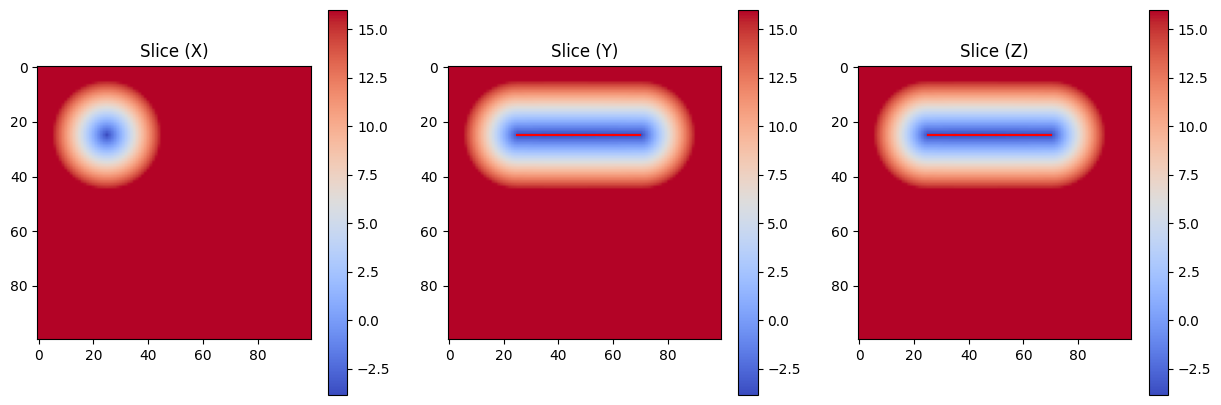

In [62]:
show_slices(np.array(loss.snake.render_distance_map_with_widths((100,100,100)).detach()), loss.snake.getGraph())

# 2d

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/3267368788.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_perfect), "2D", g)


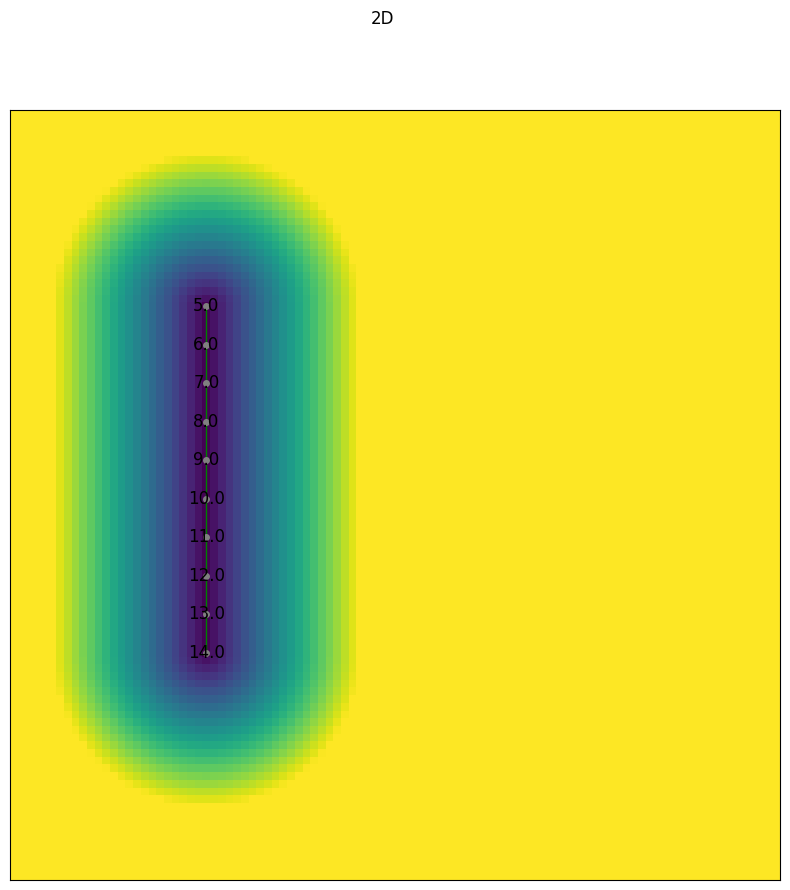

In [12]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0001
beta = 0.01
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(pred_perfect), "2D", g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [19]:
pred_initial2[:,:,:,33:34] = 6.0
pss = pred_initial2[0][0]

In [20]:
pss.shape

torch.Size([100, 100])

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/1881745071.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pss), "", g)


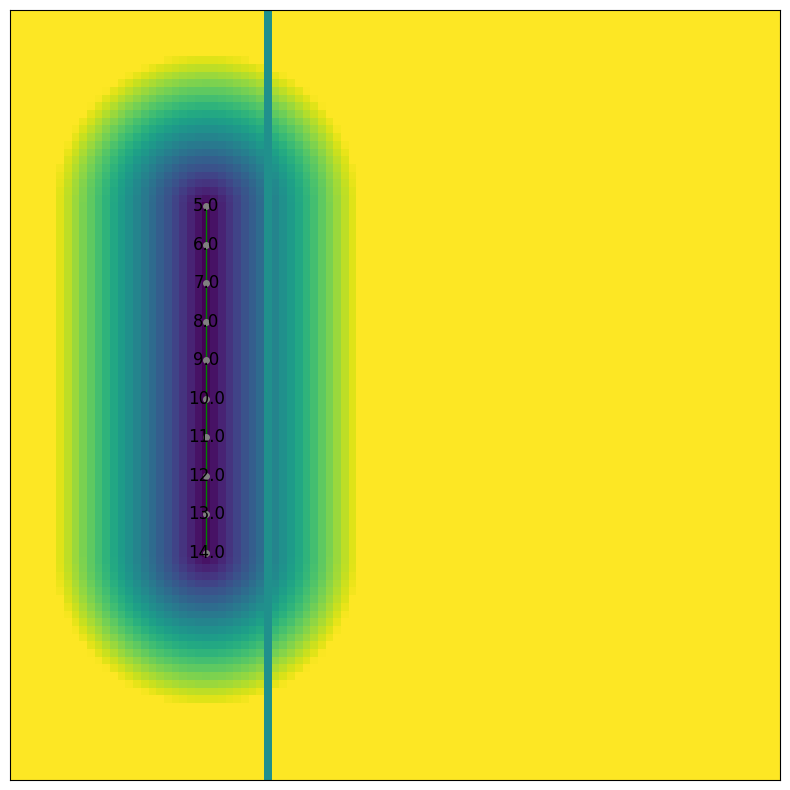

In [21]:
show(np.array(pss), "", g)

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_perfect.detach()), "",g)


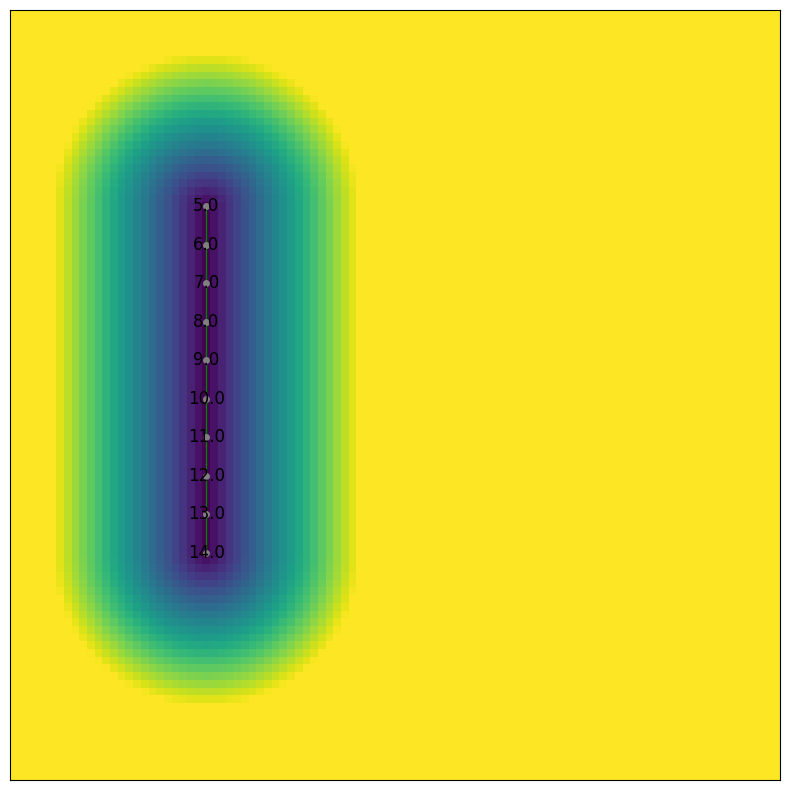

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred_initial2[0][0].detach()), "", g)


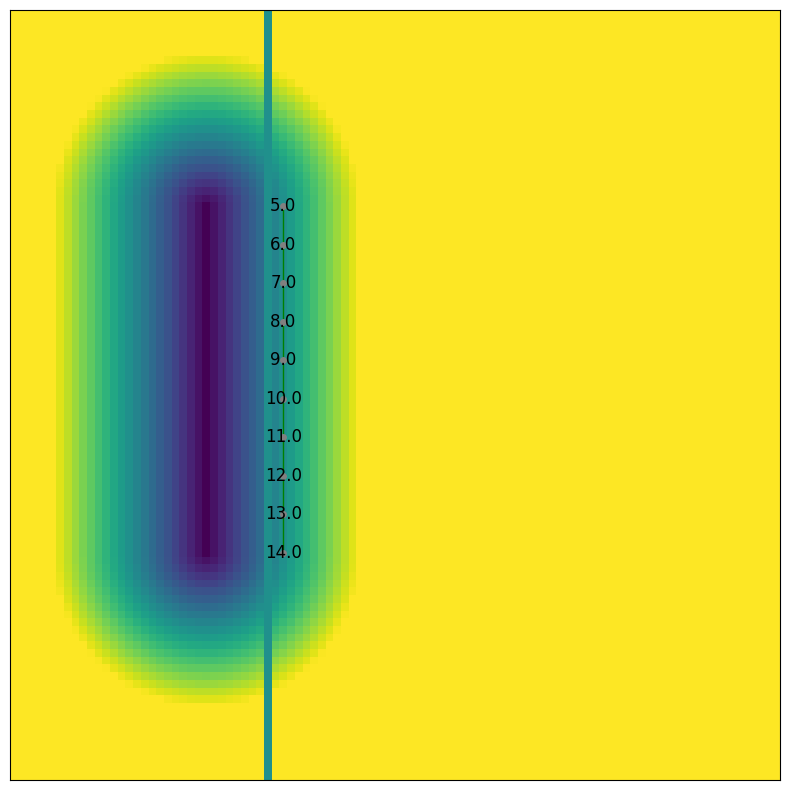

Iteration 0, Loss: 0.6621066927909851


/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(pred2.clone().detach()[0][0]), i, loss.snake.getGraph())


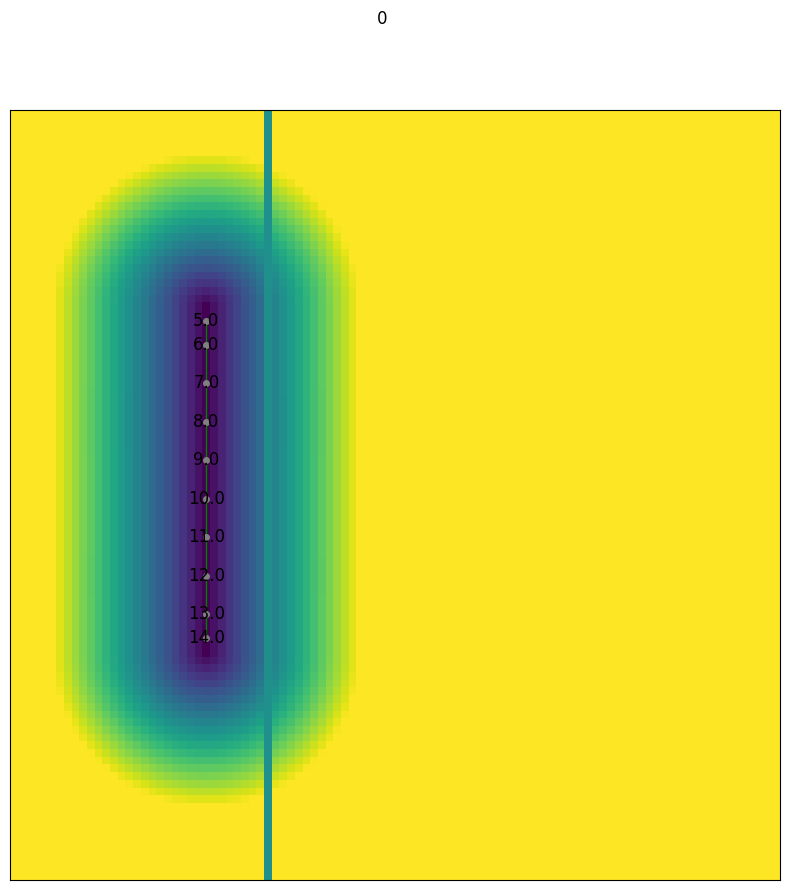

Iteration 10, Loss: 0.4901707172393799


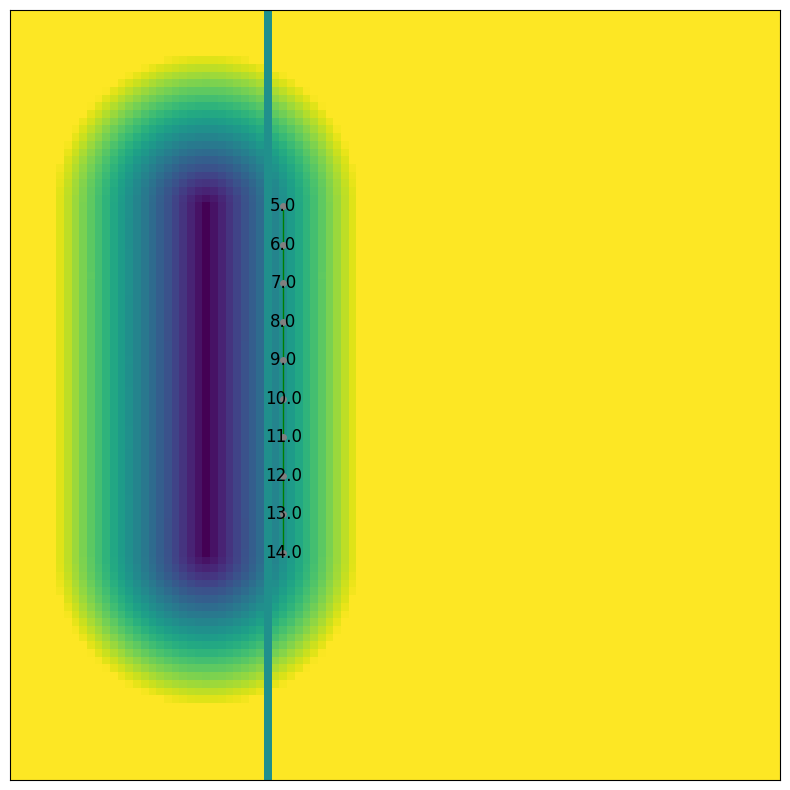

/var/folders/vw/ngjpb6v53n1bnfth8cfm07ym0000gn/T/ipykernel_1925/4042484146.py:64: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show(np.array(final_pred[0][0]), "",loss.snake.getGraph())


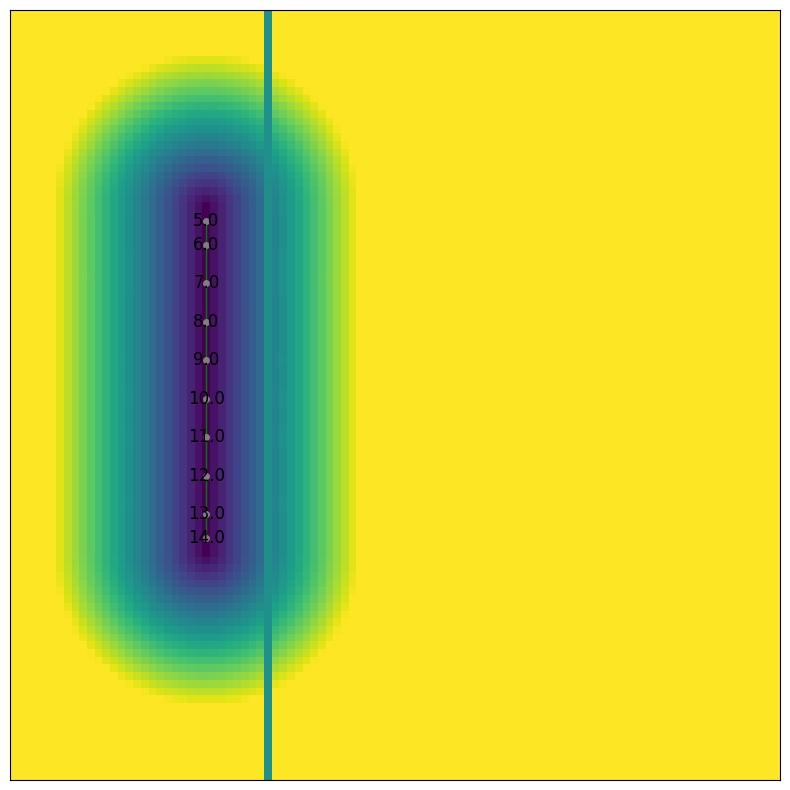

In [24]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 1
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims =2

s = RibbonSnake(g, crop, stepsz, alpha, beta, dim=ndims)
s.set_w(widths.clone().view(-1, 1))

pred_perfect = s.render_distance_map_with_widths((100,100))
 
show(np.array(pred_perfect.detach()), "",g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,:,33:34] = 6.0

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2 = pred_initial2.clone()
pred2.requires_grad_(True)

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10]) 

show(np.array(pred_initial2[0][0].detach()), "", g)

fltrstdev=1.0

opt = optim.SGD([pred2], lr=0.75, momentum=0.0)

extgradfac=1.0
nsteps=60
loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps, crop,
                                16,4,extgradfac)

for i in range(20):
    opt.zero_grad()
    loss_val = loss.forward(pred2, [g])
    loss_val.backward()
    # optimization is done on pred2
    opt.step()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss_val.item()}")
    if i % 50 == 0:
        show(np.array(pred2.clone().detach()[0][0]), i, loss.snake.getGraph())

show(pred2.detach().cpu().numpy()[0, 0], "",g)

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
show(np.array(final_pred[0][0]), "",loss.snake.getGraph())

In [ ]:
loss.snake.get_w()

tensor([-0.1390, -0.1510, -0.0563,  0.0234,  0.0906,  0.1075,  0.0899,  0.0079,
        -0.0637, -0.0723])

------------------

C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3833761391.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tangents_tensor = torch.tensor(tangents, dtype=torch.float32, device=device)
C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3954249983.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(ddd), g)


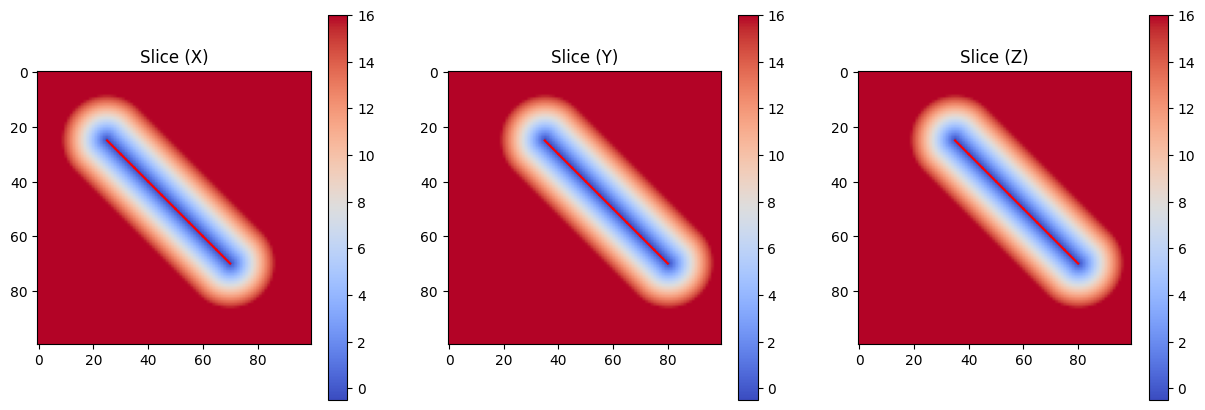

In [15]:
sa = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=3)
ddd = sa.render_distance_map((100,100,100))
show_slices(np.array(ddd), g)

In [ ]:
widths = th.tensor([5.0]*50,dtype=th.float32)
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, norms2, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf.detach().cpu(), dtype=np.float32)
tangents = np.array([tangent.detach().cpu().numpy() for tangent in tangents])

def create_circle(center, tangent, radius, normal, num_points=50):
    u = np.cross(tangent, normal)
    u = u / np.linalg.norm(u)    

    angles = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.array([center + radius * (np.cos(a) * u + np.sin(a) * normal)
                              for a in angles])
    return circle_points

circles = []
num_centers = len(centers)

for i in range(num_centers):
    center = centers[i]
    radius = widths[i]
    tangent = tangents[i]
    normal = normals[i]
    
    circle = create_circle(center, tangent, radius, normal)
    circles.append(circle)

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2522089646.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  normals = np.array(norms_perf.detach().cpu(), dtype=np.float32)


In [68]:
params = calculate_grid_parameters(centers, widths, padding=10, voxel_resolution=1.0)

In [71]:
distance_map = compute_3d_distance_map(
    centers, widths, tangents, 
    grid_shape=params['grid_shape'],
    voxel_size=params['voxel_size'],
    origin=params['origin']
)

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\3080667750.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(di), g)


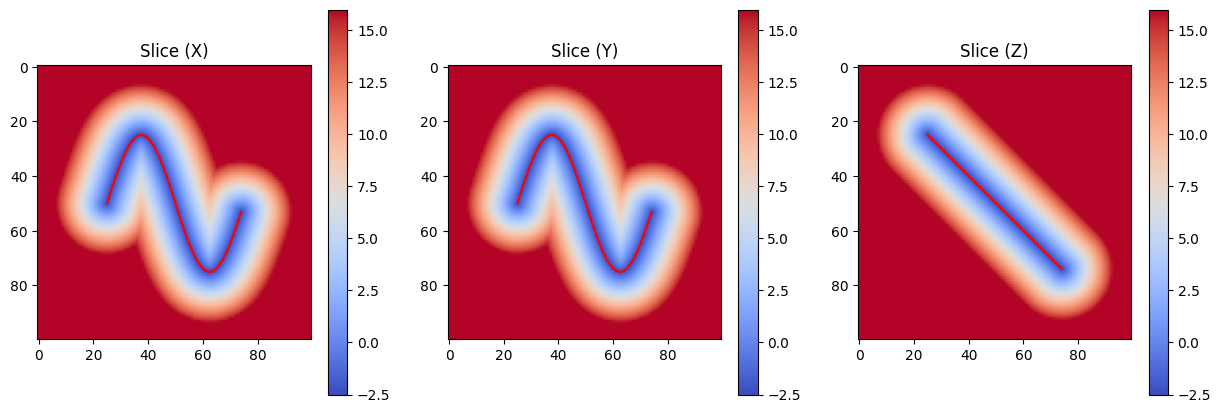

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\3080667750.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(torch.abs(di)), g)


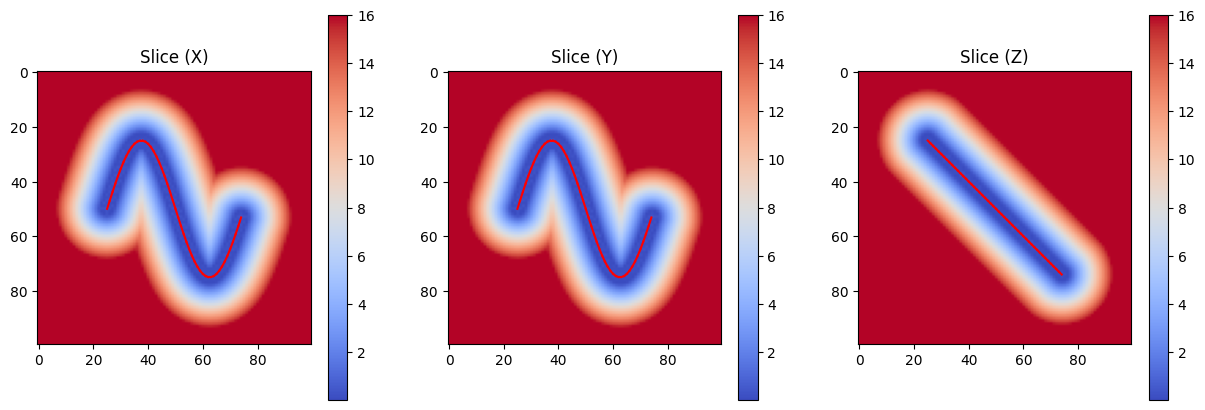

In [72]:
di = torch.clamp(distance_map, max=16)
show_slices(np.array(di), g)
show_slices(np.array(torch.abs(di)), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\1784994802.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(distance_map)


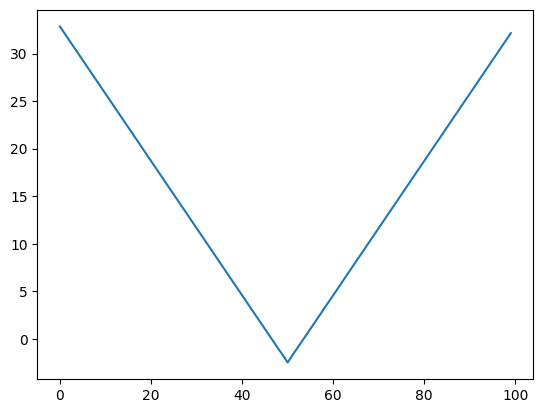

In [73]:
d = np.array(distance_map)
d = np.min(d, axis=2)
plt.plot(d[:,50])

In [74]:
fltr = makeGaussEdgeFltr(1.0,3)
fltrtr = th.from_numpy(fltr).type(th.float32)

predv = di.clone()[None,None]
predw = th.abs(di).clone()[None,None]

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

gimgv = gimgv[0]
gimgw = gimgw[0]

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2498065466.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[0]), g)


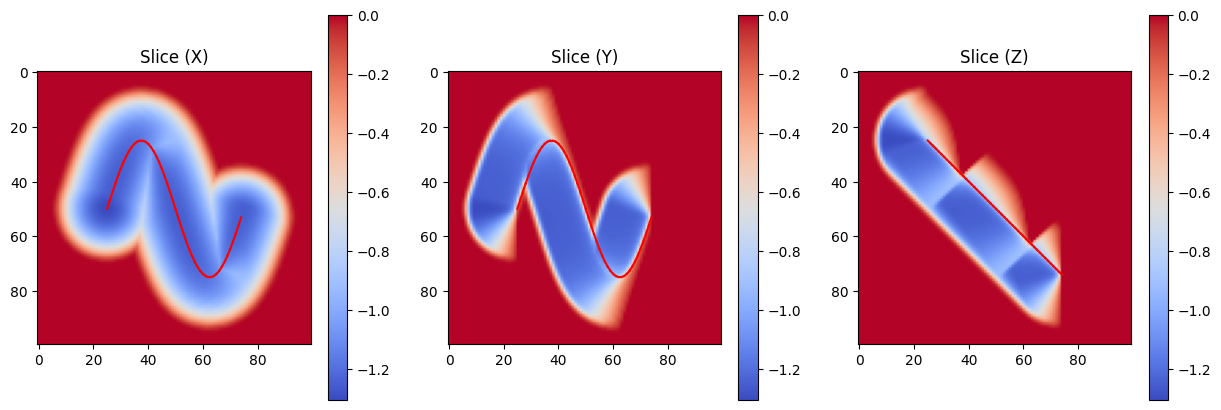

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2498065466.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[1]), g)


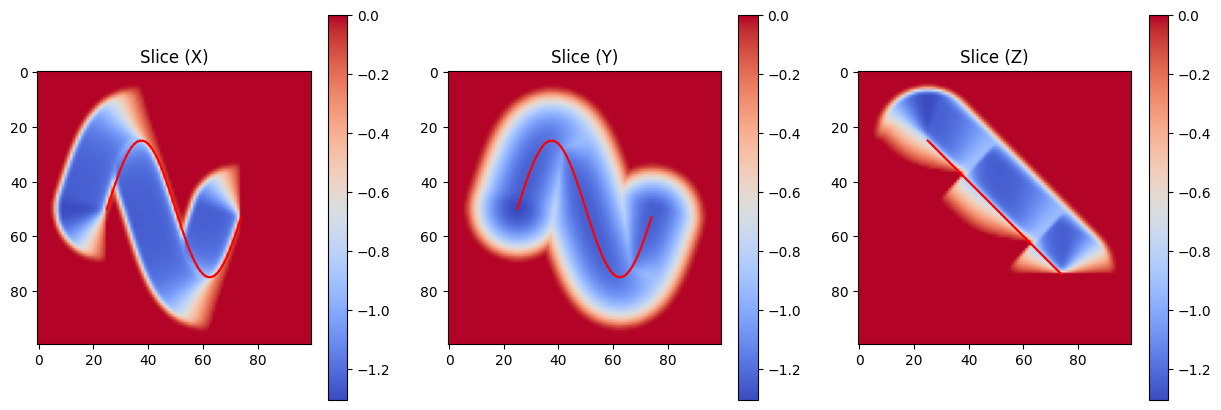

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\2498065466.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(gimgv[2]), g)


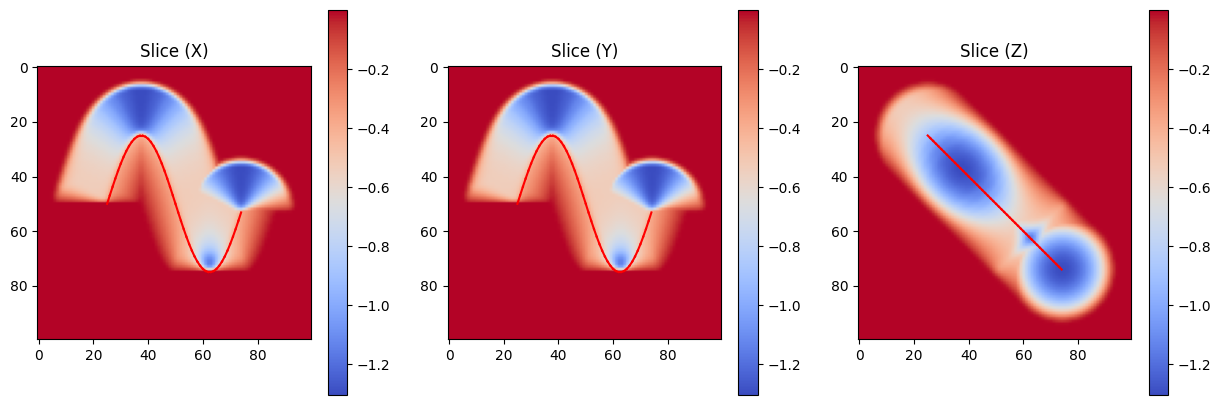

In [75]:
show_slices(np.array(gimgv[0]), g)
show_slices(np.array(gimgv[1]), g)
show_slices(np.array(gimgv[2]), g)

In [76]:
croprib=[slice(0,200), slice(0,200), slice(0,200)]
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([i,i, sin(i*2*pi/50.0)*25+50]))
    if i>25:
        g.add_edge(i,i-1)
for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,4,0])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


C:\Users\serta\AppData\Local\Temp\ipykernel_8568\1906394730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), g)


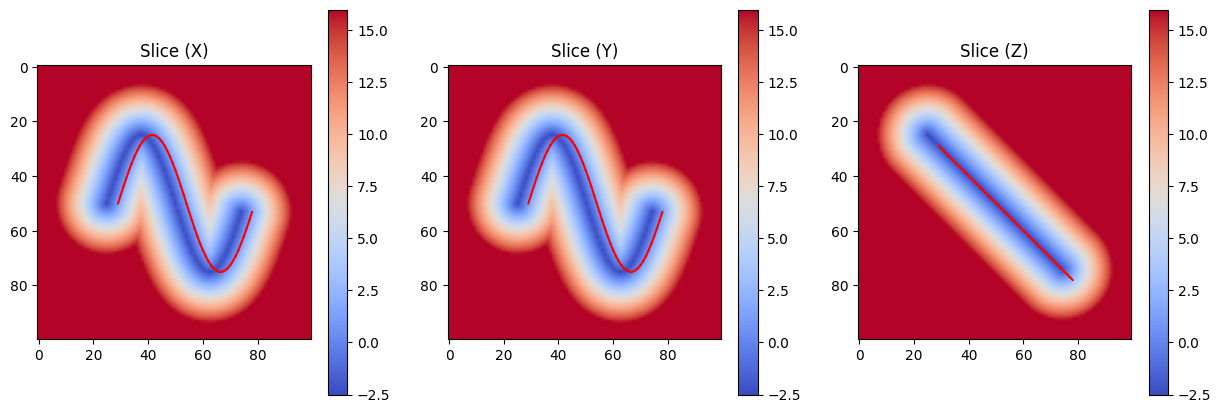

C:\Users\serta\AppData\Local\Temp\ipykernel_8568\1906394730.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(predv[0][0]), sa.getGraph())


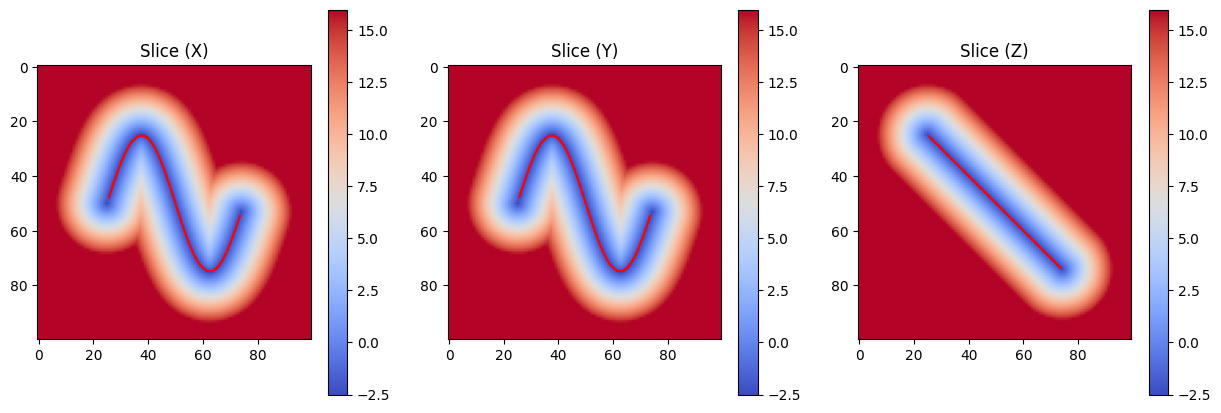

In [77]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimgv, gimgw, step_type="original", ndims=3)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
print(sa.get_w())
show_slices(np.array(predv[0][0]), g)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
show_slices(np.array(predv[0][0]), sa.getGraph())

In [78]:
sa.get_w()

tensor([[2.4538],
        [3.9162],
        [4.3532],
        [4.3865],
        [4.3939],
        [4.3887],
        [4.3812],
        [4.3842],
        [4.4035],
        [4.4176],
        [4.4085],
        [4.4055],
        [4.4006],
        [4.3875],
        [4.3813],
        [4.3806],
        [4.3751],
        [4.3625],
        [4.3816],
        [4.3968],
        [4.3925],
        [4.3805],
        [4.3759],
        [4.3742],
        [4.3743],
        [4.3731],
        [4.3730],
        [4.3767],
        [4.3846],
        [4.3891],
        [4.3887],
        [4.3812],
        [4.3842],
        [4.4035],
        [4.4176],
        [4.4085],
        [4.4055],
        [4.4006],
        [4.3875],
        [4.3813],
        [4.3806],
        [4.3751],
        [4.3625],
        [4.3816],
        [4.3968],
        [4.3945],
        [4.3805],
        [4.3521],
        [3.9377],
        [2.4836]], device='cuda:0')

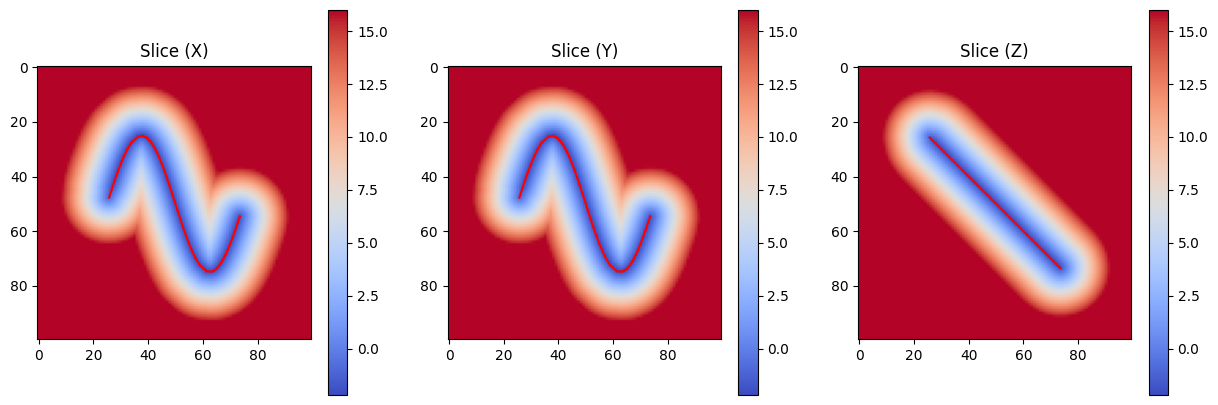

In [82]:
show_slices(sa.render_distance_map((100,100,100)).detach().cpu().numpy(), sa.getGraph()) 

In [87]:
newd = sa.render_distance_map((100,100,100)).detach().cpu().numpy()
diff = newd - predv.detach().cpu().numpy()[0][0]

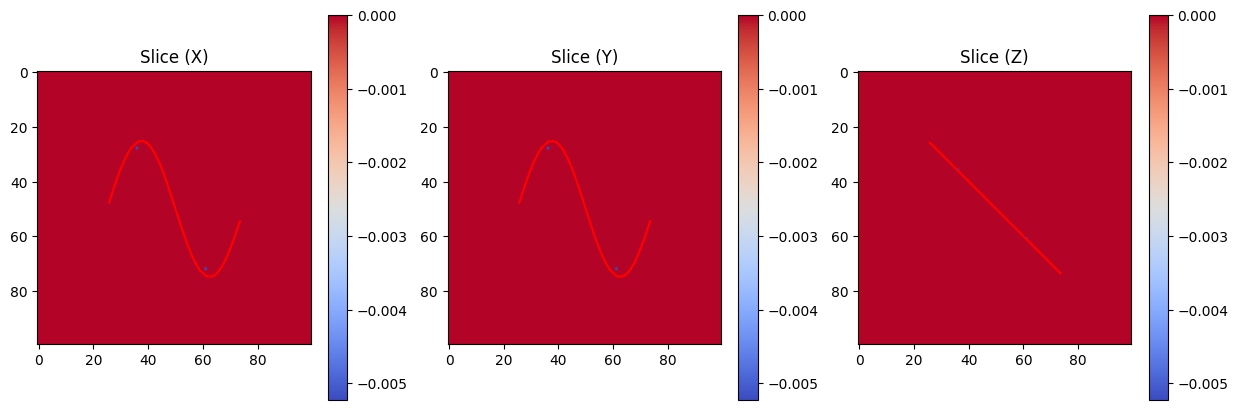

In [88]:
show_slices(diff, sa.getGraph())